<a href="https://colab.research.google.com/github/nirmal-ank/Transformers/blob/main/BERT_for_question_answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BERT for question/answering

In [ ]:
from transformers import BertTokenizerFast, BertForQuestionAnswering, pipeline, \
                         DataCollatorWithPadding, TrainingArguments, Trainer, \
                         AutoModelForQuestionAnswering, AutoTokenizer
from datasets import Dataset
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests

/home/nirmal/miniconda3/envs/TransformNLP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased', return_token_type_ids=True)

qa_bert = BertForQuestionAnswering.from_pretrained('bert-large-uncased')

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
qa_df = pd.read_csv('data/qa.csv')

qa_df.shape

(29989, 5)

In [ ]:
qa_df.head()

,question,context,start_positions,end_positions,answer
0,What sare the benifts of the blood brain barrir?,Another approach to brain function is to exami...,56,60,isolated from the bloodstream
1,What is surrounded by cerebrospinal fluid?,Another approach to brain function is to exami...,16,16,brain
2,What does the skull protect?,Another approach to brain function is to exami...,11,11,brain
3,What has been injected into rats to produce pr...,Another approach to brain function is to exami...,153,153,chemicals
4,What can cause issues with how the brain works?,Another approach to brain function is to exami...,93,94,brain damage


In [ ]:
qa_df.iloc[0]

question            What sare the benifts of the blood brain barrir?
context            Another approach to brain function is to exami...
start_positions                                                   56
end_positions                                                     60
answer                                 isolated from the bloodstream
Name: 0, dtype: object

In [ ]:
# index 56, 57, 58, 59, and 60 including question while encoding
bert_tokenizer.decode(bert_tokenizer.encode(qa_df.iloc[0].question, qa_df.iloc[0].context)[56:61])

'isolated from the bloodstream'

In [ ]:
# only grab 4,000 examples
qa_dataset = Dataset.from_pandas(qa_df.sample(4000, random_state=42))

# Dataset has a built in train test split method
qa_dataset = qa_dataset.train_test_split(test_size=0.2)

In [ ]:
# standard preprocessing here with truncation on to truncate longer text
def preprocess(data):
    return bert_tokenizer(data['question'], data['context'], truncation=True)

qa_dataset = qa_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map: 100%|██████████| 800/800 [00:00<00:00, 5342.88 examples/s]


In [ ]:
# freeze all but the last 2 encoder layers in BERT to speed up training
for name, param in qa_bert.bert.named_parameters():
    if 'encoder.layer.22' in name:
        break
    param.requires_grad = False  # disable training in BERT

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [ ]:
batch_size = 32
epochs = 6

training_args = TrainingArguments(
    output_dir='./qa/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./qa/logs',
    save_strategy='epoch',
    logging_steps=10,
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)

trainer = Trainer(
    model=qa_bert,
    args=training_args,
    train_dataset=qa_dataset['train'],
    eval_dataset=qa_dataset['test'],
    data_collator=data_collator
)

# Get initial metrics
trainer.evaluate()

/home/nirmal/miniconda3/envs/TransformNLP/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'eval_loss': 5.8613457679748535,
 'eval_model_preparation_time': 0.0058,
 'eval_runtime': 17.2417,
 'eval_samples_per_second': 46.399,
 'eval_steps_per_second': 1.45}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time
1,4.368100,4.234208,0.005800
2,3.940100,4.072306,0.005800
3,3.766800,4.040354,0.005800
4,3.531200,4.059653,0.005800
5,3.320800,4.103823,0.005800
6,3.149900,4.154438,0.005800


TrainOutput(global_step=600, training_loss=3.7600946203867593, metrics={'train_runtime': 490.6735, 'train_samples_per_second': 39.13, 'train_steps_per_second': 1.223, 'total_flos': 1.2505387914125568e+16, 'train_loss': 3.7600946203867593, 'epoch': 6.0})

In [ ]:
trainer.save_model()

In [ ]:
pipe = pipeline("question-answering", './qa/results', tokenizer=bert_tokenizer)

Device set to use cuda:0


In [ ]:
pipe("Where is Donald living these days?", "Nirmal lives in Donald but Matt lives in Kathmandu.")

/home/nirmal/miniconda3/envs/TransformNLP/lib/python3.12/site-packages/transformers/pipelines/question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


{'score': 0.14966732263565063,
 'start': 27,
 'end': 50,
 'answer': 'Matt lives in Kathmandu'}

In [ ]:
princeton = """In 1675, a Quaker missionary from England, encouraged by New Jersey proprietors John Lord
"Berkeley and Sir George Carteret, arrived to establish a settlement in this area near the
"Delaware River, which was inhabited by the Lenni-Lenape Indians. The Keith survey of 1685
"established the western boundary of Middlesex and Somerset Counties and later, the Township
"of Princeton. Today Keith's Line is recognized as Province Line Road. With the laying of the
"cornerstone for Nassau Hall in 1754, Princeton began its development as a location for
"quality education. Nassau Hall was named for William III, Prince of Orange-Nassau. This simple stone
"edifice was one of the largest public buildings in the colonies and became a model for many other
"structures in New Jersey and Pennsylvania."""

pipe("What survey led to the founding of Princeton?", princeton)

{'score': 0.006223759148269892,
 'start': 105,
 'end': 124,
 'answer': 'Sir George Carteret'}

In [ ]:
PERSON = 'Geoffrey Hinton'

# Note this is NOT an efficient way to search on google. This is done simply for education purposes
google_html = BeautifulSoup(requests.get(f'https://www.google.com/search?q={PERSON}').text).get_text()[:512]

pipe(f'Who is {PERSON}?', google_html)

{'score': 0.005018261261284351,
 'start': 0,
 'end': 15,
 'answer': 'Geoffrey Hinton'}

In [ ]:
# From Huggingface: https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad

squad_pipe = pipeline("question-answering", "bert-large-uncased-whole-word-masking-finetuned-squad")

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [ ]:
squad_pipe("Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.")

{'score': 0.9924461245536804, 'start': 15, 'end': 25, 'answer': 'California'}

In [ ]:
squad_pipe("What survey led to the founding of Princeton?", princeton)

{'score': 0.31145238876342773,
 'start': 249,
 'end': 265,
 'answer': 'The Keith survey'}

In [ ]:
# visualize logits
large_tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

qa_input = large_tokenizer(  # tokenize our example
    "What survey led to the founding of Princeton?", princeton,
    return_tensors='pt'
)

In [ ]:
large_qa_bert = AutoModelForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

output = large_qa_bert(**qa_input)  # pass the input through our QA model
output

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-5.7519, -3.6147, -8.6238, -8.5794, -8.7563, -8.1872, -8.1031, -8.2268,
         -7.5512, -9.8327, -5.7519, -6.2746, -4.7468, -7.9981, -6.5231, -6.2942,
         -6.9675, -8.3130, -7.0369, -8.2833, -6.1628, -8.1123, -5.4992, -5.6526,
         -6.2636, -8.3655, -5.3692, -7.8447, -8.8567, -6.3198, -8.5963, -5.9721,
         -7.6135, -7.3562, -8.2679, -8.3762, -6.8817, -7.8090, -7.5480, -7.4207,
         -7.2773, -8.2750, -7.7373, -7.5004, -7.8319, -7.9563, -7.1041, -5.7036,
         -7.5340, -8.4661, -8.3033, -7.9716, -7.2749, -8.5451, -8.1295, -7.2359,
         -8.6795, -8.9292, -7.6118, -8.6576, -6.9020, -5.7518,  6.3959,  5.9311,
         -1.0083, -4.0455,  1.1958, -4.5241, -2.6724, -4.6225, -3.4796, -5.6253,
         -7.3676, -5.4171, -7.9947, -5.3715, -5.9689, -8.1691, -6.2237, -7.7371,
         -4.7933, -5.0089, -6.9667, -5.7007, -3.2038, -4.9603, -4.6802,  1.7422,
         -7.9737, -6.3608, -5.4654, -7.9430, -7.3093, -7

In [ ]:
token_labels = large_tokenizer.convert_ids_to_tokens(qa_input['input_ids'].squeeze())

/tmp/ipykernel_5162/2438474572.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.start_logits.squeeze().tolist(), ci=None)


/tmp/ipykernel_5162/2438474572.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


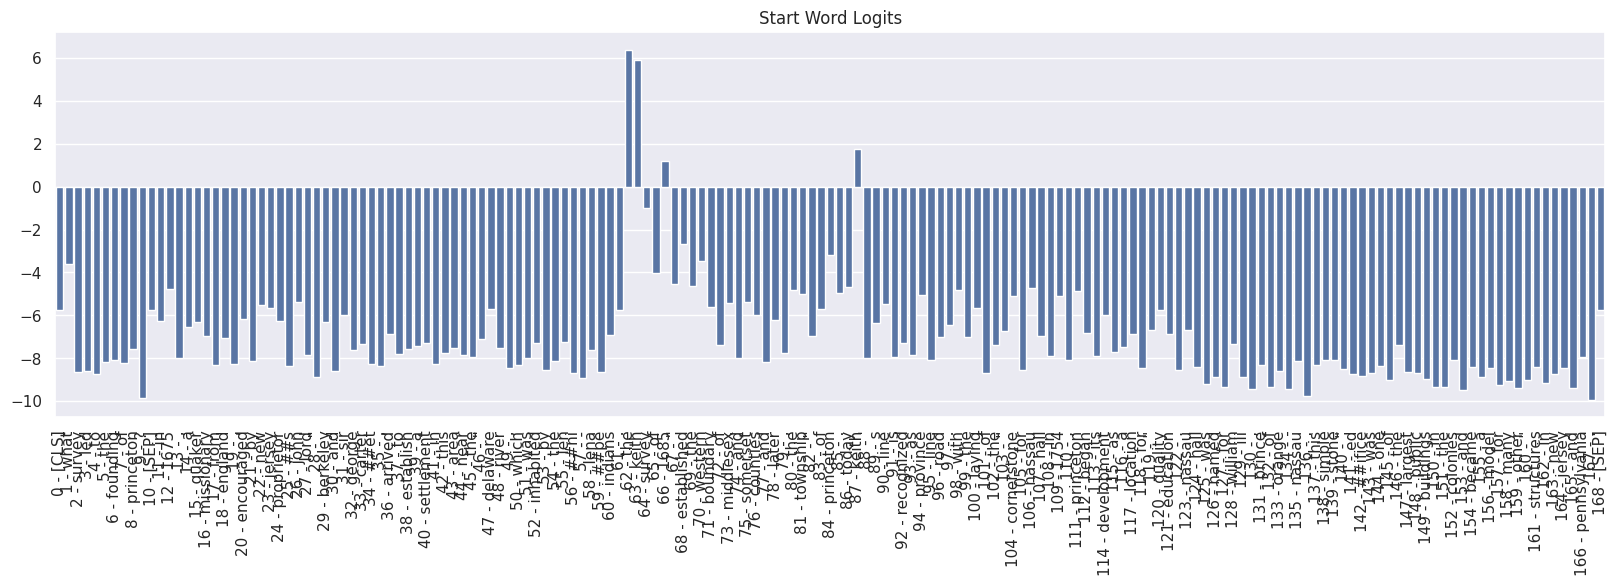

/tmp/ipykernel_5162/2438474572.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.end_logits.squeeze().tolist(), ci=None)
/tmp/ipykernel_5162/2438474572.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


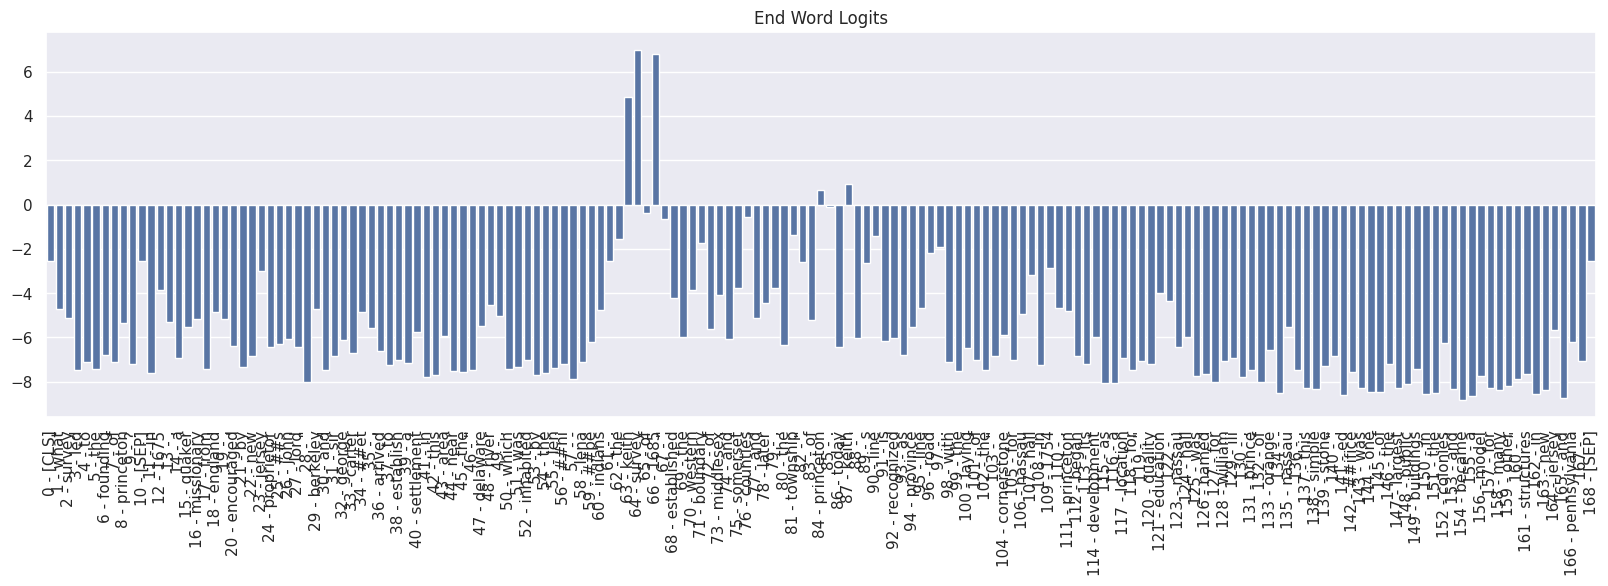

In [ ]:
# Plot start and end logits for our fine-tuned model

sns.set(rc={"figure.figsize":(20, 5)})

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.start_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('Start Word Logits')

plt.show()

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.end_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('End Word Logits')

plt.show()